In [2]:
import tensorflow as tf
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix,\
                            precision_recall_curve, average_precision_score
from scipy.interpolate import interp1d
from inspect import signature
from scipy.optimize import brentq

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os

import PIL
from PIL import Image
from tensorflow.keras import layers
import time
from scipy.stats import norm
from tqdm import tqdm

from IPython import display

import warnings

from GAN import *

warnings.filterwarnings(action='ignore')

In [3]:
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.cifar10.load_data()

In [4]:
train_data = (train_data - 127.5) / 127.5 # -1~1
test_data = (test_data - 127.5) / 127.5 # -1~1

In [5]:
# cifar10 은 컬러 이미지 이므로 채널 reshape이 필요없다.
np.shape(train_data)

(50000, 32, 32, 3)

In [6]:
np.max(train_data), np.min(train_data)

(1.0, -1.0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

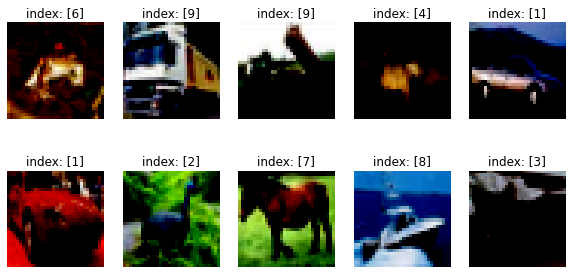

In [7]:
#데이터 출력
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_data[i])
    plt.title(f'index: {train_labels[i]}')
    plt.axis('off')
plt.show()
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


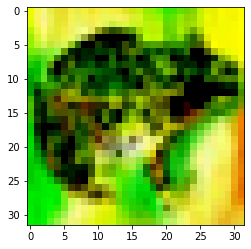

In [8]:
# 개구리는 6번이라고 한다.
for i in range(100):
    if train_labels[i]==6:
        plt.imshow(train_data[i])

그렇다 개구리는 6번이다.  
이 개구리를 anomaly로 하고  
개구리를 제외한 나머지 9가지 클래스를 생성하는 GAN모델을 구현하는 것이 목표이다.

In [9]:
# 6번 라벨(개구리)를 학습데이터셋에서 제거한다.
def set_labels(labels):
    new_t_labels = []
    for old_label in labels:
        if old_label == 6:
            new_t_labels.append([0]) #개구리는 라벨 0으로 이상치
        else:
            new_t_labels.append([1]) #그 외에는 1로 정상치
    return np.array(new_t_labels)

In [10]:
bol_train_labels = set_labels(train_labels)
bol_test_labels = set_labels(test_labels)

In [11]:
np.unique(bol_train_labels)

array([0, 1])

In [12]:
np.unique(bol_test_labels)

array([0, 1])

In [13]:
#데이터 구분하기
normal_data = []
normal_labels = []
anomaly_data = []
anomaly_labels = []
for data, label in zip(train_data, bol_train_labels):
    if label == 0:
        anomaly_data.append(data)
        anomaly_labels.append(label)
    else:
        normal_data.append(data)
        normal_labels.append(label)
        
normal_data = np.array(normal_data)
normal_labels = np.array(normal_labels)
anomaly_data = np.array(anomaly_data)
anomaly_labels = np.array(anomaly_labels)

In [14]:
print(normal_data.shape, normal_labels.shape)
print(anomaly_data.shape, anomaly_labels.shape)

(45000, 32, 32, 3) (45000, 1)
(5000, 32, 32, 3) (5000, 1)


In [15]:
# 기존의 다중클래스 분류 문제에서 정상치 혹은 이상치를 분류하는 이진분류 문제로 바뀜

train_data = normal_data
bol_train_labels = normal_labels

test_data =tf.concat([test_data, anomaly_data], 0)
bol_test_labels = tf.concat([bol_test_labels, anomaly_labels], 0)

In [16]:
print(train_data.shape)
print(test_data.shape)
print(bol_train_labels.shape)
print(bol_test_labels.shape)

(45000, 32, 32, 3)
(15000, 32, 32, 3)
(45000, 1)
(15000, 1)


In [17]:
for label in bol_train_labels:
    if label == 0:
        print(label)
print("Done")

Done


In [18]:
#train_data set에는 라벨이 1인 데이터만 있어야하고
#test_data set에는 라벨이 0과 1인 데이터 모두 있어야한다.
BUFFER_SIZE = 10000
BATCH_SIZE = 8

#분리되어 있던 두 array를 하나의 데이터셋으로 묶음
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, bol_train_labels))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_data, bol_test_labels))
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [19]:
for data, label in train_dataset.take(1):
    print(label)

tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]], shape=(8, 1), dtype=int64)


In [20]:
for data, label in test_dataset.take(1):
    print(label)

tf.Tensor(
[[1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]], shape=(8, 1), dtype=int64)


In [21]:
generator = Generator(num_output_channel=3)  # Generator가 32X32X1 짜리 이미지를 생성해야 합니다. 
discriminator = Discriminator()

### Loss function

In [22]:
l2_loss = tf.keras.losses.MeanSquaredError()
l1_loss = tf.keras.losses.MeanAbsoluteError()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [23]:
def discriminator_loss(pred_real, pred_fake):
    real_loss = cross_entropy(tf.ones_like(pred_real), pred_real)
    fake_loss = cross_entropy(tf.zeros_like(pred_fake), pred_fake)
    
    total_dis_loss = (real_loss + fake_loss) * 0.5
    
    return total_dis_loss

In [24]:
def generator_loss(real_output, fake_output, input_data, gen_data, latent_first, latent_sec):
    w_adv = 1.
    w_context = 40.
    w_encoder = 1.
    
    adv_loss = cross_entropy(real_output, fake_output)
    context_loss = l1_loss(input_data, gen_data)
    encoder_loss = l2_loss(latent_first, latent_sec)
    
    total_gen_loss = w_adv * adv_loss + \
                     w_context * context_loss + \
                     w_encoder * encoder_loss
    
    return total_gen_loss

In [25]:
# Optimizer 설정
generator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)

### Model Train

In [26]:
def train_step(images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(images, training=True)
        
        pred_real, feat_real = discriminator(images, training=True)
        pred_fake, feat_fake = discriminator(generated_images, training=True)

        gen_loss = generator_loss(pred_real, pred_fake,
                                  images, generated_images,
                                  feat_real, feat_fake)

        disc_loss = discriminator_loss(pred_real, pred_fake)        

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [27]:
checkpoint_path = os.path.join(os.getenv('HOME'),'aiffel/ganomaly_skip_no_norm/ckpt')

if not os.path.isdir(checkpoint_path):
    os.makedirs(checkpoint_path)
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [28]:
i = 0
for a, b in train_dataset:
    print(np.shape(a))
    i +=1
    if i == 5:
        break

(8, 32, 32, 3)
(8, 32, 32, 3)
(8, 32, 32, 3)
(8, 32, 32, 3)
(8, 32, 32, 3)


In [29]:
max_epochs = 25
steps = 0

for epoch in range(max_epochs):
    start = time.time()

    for images, labels in tqdm(train_dataset):
        steps += 1
        gen_loss, disc_loss = train_step(images)
        
        if steps % 100 == 0:
            print ('Steps : {}, \t Total Gen Loss : {}, \t Total Dis Loss : {}'.format(steps, gen_loss.numpy(), disc_loss.numpy()))
        
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
        
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

  0%|          | 0/5625 [00:00<?, ?it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



  2%|▏         | 103/5625 [00:19<04:26, 20.72it/s] 

Steps : 100, 	 Total Gen Loss : 18.09758949279785, 	 Total Dis Loss : 0.6908904314041138


  4%|▎         | 202/5625 [00:23<04:27, 20.25it/s]

Steps : 200, 	 Total Gen Loss : 12.285405158996582, 	 Total Dis Loss : 0.6992862224578857


  5%|▌         | 302/5625 [00:28<04:29, 19.77it/s]

Steps : 300, 	 Total Gen Loss : 13.496633529663086, 	 Total Dis Loss : 0.4701506793498993


  7%|▋         | 402/5625 [00:33<04:19, 20.14it/s]

Steps : 400, 	 Total Gen Loss : 17.38485336303711, 	 Total Dis Loss : 0.15806937217712402


  9%|▉         | 503/5625 [00:38<04:12, 20.26it/s]

Steps : 500, 	 Total Gen Loss : 15.143692970275879, 	 Total Dis Loss : 0.48792415857315063


 11%|█         | 603/5625 [00:44<04:18, 19.44it/s]

Steps : 600, 	 Total Gen Loss : 19.084728240966797, 	 Total Dis Loss : 0.08636796474456787


 12%|█▏        | 702/5625 [00:49<04:14, 19.31it/s]

Steps : 700, 	 Total Gen Loss : 16.768144607543945, 	 Total Dis Loss : 0.07284843921661377


 14%|█▍        | 804/5625 [00:54<03:53, 20.62it/s]

Steps : 800, 	 Total Gen Loss : 19.85403823852539, 	 Total Dis Loss : 0.08993649482727051


 16%|█▌        | 903/5625 [00:58<03:45, 20.95it/s]

Steps : 900, 	 Total Gen Loss : 21.526784896850586, 	 Total Dis Loss : 0.02953755483031273


 18%|█▊        | 1002/5625 [01:03<03:58, 19.40it/s]

Steps : 1000, 	 Total Gen Loss : 22.43745231628418, 	 Total Dis Loss : 0.047380294650793076


 20%|█▉        | 1103/5625 [01:08<03:47, 19.83it/s]

Steps : 1100, 	 Total Gen Loss : 21.11842918395996, 	 Total Dis Loss : 0.14517608284950256


 21%|██▏       | 1202/5625 [01:14<03:48, 19.36it/s]

Steps : 1200, 	 Total Gen Loss : 18.425264358520508, 	 Total Dis Loss : 0.04113587737083435


 23%|██▎       | 1302/5625 [01:19<03:56, 18.30it/s]

Steps : 1300, 	 Total Gen Loss : 18.652971267700195, 	 Total Dis Loss : 0.016283361241221428


 25%|██▍       | 1404/5625 [01:24<03:23, 20.73it/s]

Steps : 1400, 	 Total Gen Loss : 18.480817794799805, 	 Total Dis Loss : 0.016191713511943817


 27%|██▋       | 1503/5625 [01:29<03:20, 20.56it/s]

Steps : 1500, 	 Total Gen Loss : 20.06055450439453, 	 Total Dis Loss : 0.039794594049453735


 28%|██▊       | 1603/5625 [01:34<03:23, 19.76it/s]

Steps : 1600, 	 Total Gen Loss : 21.45485496520996, 	 Total Dis Loss : 0.017063342034816742


 30%|███       | 1703/5625 [01:39<03:11, 20.49it/s]

Steps : 1700, 	 Total Gen Loss : 17.005281448364258, 	 Total Dis Loss : 0.31534379720687866


 32%|███▏      | 1803/5625 [01:44<03:15, 19.53it/s]

Steps : 1800, 	 Total Gen Loss : 21.17102813720703, 	 Total Dis Loss : 0.009399796836078167


 34%|███▍      | 1903/5625 [01:49<03:06, 19.98it/s]

Steps : 1900, 	 Total Gen Loss : 21.363513946533203, 	 Total Dis Loss : 0.006693784147500992


 36%|███▌      | 2004/5625 [01:54<02:57, 20.43it/s]

Steps : 2000, 	 Total Gen Loss : 21.63405990600586, 	 Total Dis Loss : 0.09486342966556549


 37%|███▋      | 2104/5625 [01:59<02:50, 20.65it/s]

Steps : 2100, 	 Total Gen Loss : 23.30635643005371, 	 Total Dis Loss : 0.03261305019259453


 39%|███▉      | 2203/5625 [02:03<02:45, 20.71it/s]

Steps : 2200, 	 Total Gen Loss : 20.97881317138672, 	 Total Dis Loss : 0.01963767409324646


 41%|████      | 2303/5625 [02:08<02:51, 19.41it/s]

Steps : 2300, 	 Total Gen Loss : 21.570465087890625, 	 Total Dis Loss : 0.08606234937906265


 43%|████▎     | 2404/5625 [02:14<02:40, 20.13it/s]

Steps : 2400, 	 Total Gen Loss : 19.375320434570312, 	 Total Dis Loss : 0.2519603967666626


 44%|████▍     | 2502/5625 [02:18<02:41, 19.39it/s]

Steps : 2500, 	 Total Gen Loss : 22.31700897216797, 	 Total Dis Loss : 0.00584446033462882


 46%|████▋     | 2602/5625 [02:24<02:34, 19.58it/s]

Steps : 2600, 	 Total Gen Loss : 21.184553146362305, 	 Total Dis Loss : 0.0128305833786726


 48%|████▊     | 2703/5625 [02:29<02:29, 19.54it/s]

Steps : 2700, 	 Total Gen Loss : 22.541889190673828, 	 Total Dis Loss : 0.01424316130578518


 50%|████▉     | 2802/5625 [02:34<02:25, 19.44it/s]

Steps : 2800, 	 Total Gen Loss : 25.370019912719727, 	 Total Dis Loss : 0.003429509699344635


 52%|█████▏    | 2903/5625 [02:39<02:16, 19.99it/s]

Steps : 2900, 	 Total Gen Loss : 23.741409301757812, 	 Total Dis Loss : 0.01215396448969841


 53%|█████▎    | 3004/5625 [02:44<02:07, 20.56it/s]

Steps : 3000, 	 Total Gen Loss : 21.715238571166992, 	 Total Dis Loss : 0.07423792779445648


 55%|█████▌    | 3103/5625 [02:49<02:02, 20.56it/s]

Steps : 3100, 	 Total Gen Loss : 22.693788528442383, 	 Total Dis Loss : 0.019610287621617317


 57%|█████▋    | 3203/5625 [02:54<02:02, 19.79it/s]

Steps : 3200, 	 Total Gen Loss : 22.709003448486328, 	 Total Dis Loss : 0.05231755971908569


 59%|█████▊    | 3304/5625 [02:59<01:52, 20.69it/s]

Steps : 3300, 	 Total Gen Loss : 18.899198532104492, 	 Total Dis Loss : 0.004977914970368147


 60%|██████    | 3403/5625 [03:04<01:47, 20.60it/s]

Steps : 3400, 	 Total Gen Loss : 17.55922508239746, 	 Total Dis Loss : 0.032201576977968216


 62%|██████▏   | 3501/5625 [03:08<01:46, 20.00it/s]

Steps : 3500, 	 Total Gen Loss : 22.80820083618164, 	 Total Dis Loss : 0.006244771182537079


 64%|██████▍   | 3602/5625 [03:13<01:39, 20.24it/s]

Steps : 3600, 	 Total Gen Loss : 24.1280574798584, 	 Total Dis Loss : 0.003238431643694639


 66%|██████▌   | 3701/5625 [03:18<01:36, 20.02it/s]

Steps : 3700, 	 Total Gen Loss : 24.624061584472656, 	 Total Dis Loss : 0.026250815019011497


 68%|██████▊   | 3803/5625 [03:23<01:29, 20.42it/s]

Steps : 3800, 	 Total Gen Loss : 23.647424697875977, 	 Total Dis Loss : 0.0067538367584347725


 69%|██████▉   | 3903/5625 [03:28<01:26, 20.00it/s]

Steps : 3900, 	 Total Gen Loss : 19.841018676757812, 	 Total Dis Loss : 0.01759367436170578


 71%|███████   | 4003/5625 [03:33<01:23, 19.53it/s]

Steps : 4000, 	 Total Gen Loss : 22.957679748535156, 	 Total Dis Loss : 0.00672903610393405


 73%|███████▎  | 4102/5625 [03:38<01:16, 19.96it/s]

Steps : 4100, 	 Total Gen Loss : 19.802091598510742, 	 Total Dis Loss : 0.3049519658088684


 75%|███████▍  | 4203/5625 [03:43<01:09, 20.41it/s]

Steps : 4200, 	 Total Gen Loss : 21.051359176635742, 	 Total Dis Loss : 0.006209269165992737


 76%|███████▋  | 4302/5625 [03:48<01:06, 19.93it/s]

Steps : 4300, 	 Total Gen Loss : 25.960247039794922, 	 Total Dis Loss : 0.0024284743703901768


 78%|███████▊  | 4403/5625 [03:53<01:00, 20.24it/s]

Steps : 4400, 	 Total Gen Loss : 20.871490478515625, 	 Total Dis Loss : 0.01829429343342781


 80%|████████  | 4503/5625 [03:58<00:56, 19.99it/s]

Steps : 4500, 	 Total Gen Loss : 22.711959838867188, 	 Total Dis Loss : 0.01152865495532751


 82%|████████▏ | 4602/5625 [04:03<00:49, 20.62it/s]

Steps : 4600, 	 Total Gen Loss : 18.974533081054688, 	 Total Dis Loss : 0.03767503798007965


 84%|████████▎ | 4703/5625 [04:08<00:46, 19.64it/s]

Steps : 4700, 	 Total Gen Loss : 20.644020080566406, 	 Total Dis Loss : 0.02977900207042694


 85%|████████▌ | 4803/5625 [04:13<00:39, 20.55it/s]

Steps : 4800, 	 Total Gen Loss : 21.748912811279297, 	 Total Dis Loss : 0.0036187476944178343


 87%|████████▋ | 4903/5625 [04:18<00:35, 20.19it/s]

Steps : 4900, 	 Total Gen Loss : 20.583730697631836, 	 Total Dis Loss : 0.04571957886219025


 89%|████████▉ | 5002/5625 [04:23<00:30, 20.52it/s]

Steps : 5000, 	 Total Gen Loss : 21.91748046875, 	 Total Dis Loss : 0.08843086659908295


 91%|█████████ | 5102/5625 [04:28<00:26, 19.53it/s]

Steps : 5100, 	 Total Gen Loss : 23.135908126831055, 	 Total Dis Loss : 0.0024308585561811924


 92%|█████████▏| 5202/5625 [04:33<00:20, 20.35it/s]

Steps : 5200, 	 Total Gen Loss : 22.013235092163086, 	 Total Dis Loss : 0.00804128311574459


 94%|█████████▍| 5301/5625 [04:38<00:16, 20.14it/s]

Steps : 5300, 	 Total Gen Loss : 21.819726943969727, 	 Total Dis Loss : 0.003124289447441697


 96%|█████████▌| 5404/5625 [04:43<00:11, 19.87it/s]

Steps : 5400, 	 Total Gen Loss : 23.27488136291504, 	 Total Dis Loss : 0.0034113882575184107


 98%|█████████▊| 5503/5625 [04:48<00:06, 19.39it/s]

Steps : 5500, 	 Total Gen Loss : 21.41492462158203, 	 Total Dis Loss : 0.09109894931316376


100%|█████████▉| 5604/5625 [04:53<00:01, 20.13it/s]

Steps : 5600, 	 Total Gen Loss : 19.316986083984375, 	 Total Dis Loss : 0.0029348311945796013


  0%|          | 0/5625 [00:00<?, ?it/s]

Time for epoch 1 is 294.71154737472534 sec


  1%|▏         | 79/5625 [00:04<04:36, 20.05it/s]

Steps : 5700, 	 Total Gen Loss : 21.551227569580078, 	 Total Dis Loss : 0.030084669589996338


  3%|▎         | 177/5625 [00:09<04:33, 19.92it/s]

Steps : 5800, 	 Total Gen Loss : 23.14217758178711, 	 Total Dis Loss : 0.006253552623093128


  5%|▍         | 277/5625 [00:14<04:27, 19.98it/s]

Steps : 5900, 	 Total Gen Loss : 24.176713943481445, 	 Total Dis Loss : 0.0032672700472176075


  7%|▋         | 379/5625 [00:19<04:17, 20.36it/s]

Steps : 6000, 	 Total Gen Loss : 21.787843704223633, 	 Total Dis Loss : 0.002725407714024186


  8%|▊         | 478/5625 [00:24<04:08, 20.71it/s]

Steps : 6100, 	 Total Gen Loss : 24.81146240234375, 	 Total Dis Loss : 0.004786189645528793


 10%|█         | 578/5625 [00:29<04:06, 20.48it/s]

Steps : 6200, 	 Total Gen Loss : 22.495155334472656, 	 Total Dis Loss : 0.0015888528432697058


 12%|█▏        | 677/5625 [00:33<04:04, 20.25it/s]

Steps : 6300, 	 Total Gen Loss : 29.640968322753906, 	 Total Dis Loss : 0.006218377500772476


 14%|█▍        | 779/5625 [00:39<03:58, 20.30it/s]

Steps : 6400, 	 Total Gen Loss : 23.45204734802246, 	 Total Dis Loss : 0.0038765110075473785


 16%|█▌        | 878/5625 [00:43<03:56, 20.10it/s]

Steps : 6500, 	 Total Gen Loss : 22.577251434326172, 	 Total Dis Loss : 0.008271325379610062


 17%|█▋        | 979/5625 [00:48<03:46, 20.53it/s]

Steps : 6600, 	 Total Gen Loss : 22.660547256469727, 	 Total Dis Loss : 0.0029532145708799362


 19%|█▉        | 1078/5625 [00:53<03:44, 20.29it/s]

Steps : 6700, 	 Total Gen Loss : 23.407541275024414, 	 Total Dis Loss : 0.008503168821334839


 21%|██        | 1177/5625 [00:58<03:33, 20.80it/s]

Steps : 6800, 	 Total Gen Loss : 19.742969512939453, 	 Total Dis Loss : 0.024120209738612175


 23%|██▎       | 1279/5625 [01:03<03:30, 20.67it/s]

Steps : 6900, 	 Total Gen Loss : 22.577728271484375, 	 Total Dis Loss : 0.005270780995488167


 24%|██▍       | 1378/5625 [01:08<03:28, 20.40it/s]

Steps : 7000, 	 Total Gen Loss : 24.962617874145508, 	 Total Dis Loss : 0.0019277107203379273


 26%|██▋       | 1477/5625 [01:13<03:26, 20.05it/s]

Steps : 7100, 	 Total Gen Loss : 21.56376838684082, 	 Total Dis Loss : 0.0090256929397583


 28%|██▊       | 1578/5625 [01:18<03:23, 19.85it/s]

Steps : 7200, 	 Total Gen Loss : 21.615093231201172, 	 Total Dis Loss : 0.0076367612928152084


 30%|██▉       | 1677/5625 [01:23<03:16, 20.07it/s]

Steps : 7300, 	 Total Gen Loss : 23.345172882080078, 	 Total Dis Loss : 0.00164350017439574


 32%|███▏      | 1778/5625 [01:28<03:16, 19.62it/s]

Steps : 7400, 	 Total Gen Loss : 21.621339797973633, 	 Total Dis Loss : 0.002613301854580641


 33%|███▎      | 1879/5625 [01:33<03:04, 20.34it/s]

Steps : 7500, 	 Total Gen Loss : 24.071971893310547, 	 Total Dis Loss : 0.001920528942719102


 35%|███▌      | 1978/5625 [01:38<02:58, 20.42it/s]

Steps : 7600, 	 Total Gen Loss : 24.694360733032227, 	 Total Dis Loss : 0.0038676648400723934


 37%|███▋      | 2079/5625 [01:43<02:59, 19.74it/s]

Steps : 7700, 	 Total Gen Loss : 26.285127639770508, 	 Total Dis Loss : 0.0019719486590474844


 39%|███▊      | 2179/5625 [01:48<02:51, 20.08it/s]

Steps : 7800, 	 Total Gen Loss : 23.59560203552246, 	 Total Dis Loss : 0.01105712354183197


 40%|████      | 2277/5625 [01:53<02:45, 20.19it/s]

Steps : 7900, 	 Total Gen Loss : 23.295732498168945, 	 Total Dis Loss : 0.0021842890419065952


 42%|████▏     | 2378/5625 [01:58<02:57, 18.32it/s]

Steps : 8000, 	 Total Gen Loss : 20.5295467376709, 	 Total Dis Loss : 0.004898400977253914


 44%|████▍     | 2477/5625 [02:03<02:45, 19.00it/s]

Steps : 8100, 	 Total Gen Loss : 23.38129997253418, 	 Total Dis Loss : 0.012093140743672848


 46%|████▌     | 2578/5625 [02:08<02:33, 19.85it/s]

Steps : 8200, 	 Total Gen Loss : 21.870033264160156, 	 Total Dis Loss : 0.0012199567863717675


 48%|████▊     | 2679/5625 [02:13<02:22, 20.71it/s]

Steps : 8300, 	 Total Gen Loss : 22.059078216552734, 	 Total Dis Loss : 0.001077102031558752


 49%|████▉     | 2777/5625 [02:18<02:21, 20.07it/s]

Steps : 8400, 	 Total Gen Loss : 25.265933990478516, 	 Total Dis Loss : 0.0005471208714880049


 51%|█████     | 2877/5625 [02:23<02:16, 20.15it/s]

Steps : 8500, 	 Total Gen Loss : 23.5383358001709, 	 Total Dis Loss : 0.001266321400180459


 53%|█████▎    | 2977/5625 [02:28<02:12, 19.93it/s]

Steps : 8600, 	 Total Gen Loss : 23.743228912353516, 	 Total Dis Loss : 0.0010598998051136732


 55%|█████▍    | 3079/5625 [02:33<02:02, 20.73it/s]

Steps : 8700, 	 Total Gen Loss : 27.05609893798828, 	 Total Dis Loss : 0.0008754330920055509


 56%|█████▋    | 3178/5625 [02:38<02:03, 19.84it/s]

Steps : 8800, 	 Total Gen Loss : 21.166032791137695, 	 Total Dis Loss : 0.002119809854775667


 58%|█████▊    | 3278/5625 [02:43<01:54, 20.54it/s]

Steps : 8900, 	 Total Gen Loss : 22.680774688720703, 	 Total Dis Loss : 0.004104188643395901


 60%|██████    | 3377/5625 [02:48<01:52, 20.00it/s]

Steps : 9000, 	 Total Gen Loss : 24.052387237548828, 	 Total Dis Loss : 0.0013174177147448063


 62%|██████▏   | 3477/5625 [02:53<01:45, 20.28it/s]

Steps : 9100, 	 Total Gen Loss : 23.708389282226562, 	 Total Dis Loss : 0.011973939836025238


 64%|██████▎   | 3579/5625 [02:58<01:39, 20.47it/s]

Steps : 9200, 	 Total Gen Loss : 24.113384246826172, 	 Total Dis Loss : 0.0007582304533571005


 65%|██████▌   | 3678/5625 [03:03<01:39, 19.67it/s]

Steps : 9300, 	 Total Gen Loss : 27.77814292907715, 	 Total Dis Loss : 0.0002674511633813381


 67%|██████▋   | 3778/5625 [03:08<01:33, 19.68it/s]

Steps : 9400, 	 Total Gen Loss : 24.664581298828125, 	 Total Dis Loss : 0.0005197487189434469


 69%|██████▉   | 3877/5625 [03:13<01:26, 20.11it/s]

Steps : 9500, 	 Total Gen Loss : 24.253372192382812, 	 Total Dis Loss : 0.0022071320563554764


 71%|███████   | 3976/5625 [03:18<01:23, 19.77it/s]

Steps : 9600, 	 Total Gen Loss : 25.764484405517578, 	 Total Dis Loss : 0.000215979729546234


 72%|███████▏  | 4077/5625 [03:23<01:16, 20.26it/s]

Steps : 9700, 	 Total Gen Loss : 20.328392028808594, 	 Total Dis Loss : 0.056780289858579636


 74%|███████▍  | 4179/5625 [03:28<01:10, 20.47it/s]

Steps : 9800, 	 Total Gen Loss : 24.92567253112793, 	 Total Dis Loss : 0.000620093836914748


 76%|███████▌  | 4277/5625 [03:33<01:07, 19.93it/s]

Steps : 9900, 	 Total Gen Loss : 20.256467819213867, 	 Total Dis Loss : 0.0010725646279752254


 78%|███████▊  | 4378/5625 [03:38<01:01, 20.22it/s]

Steps : 10000, 	 Total Gen Loss : 24.334999084472656, 	 Total Dis Loss : 0.0014958656392991543


 80%|███████▉  | 4477/5625 [03:42<00:56, 20.44it/s]

Steps : 10100, 	 Total Gen Loss : 21.721080780029297, 	 Total Dis Loss : 0.06006404757499695


 81%|████████▏ | 4579/5625 [03:48<00:52, 19.84it/s]

Steps : 10200, 	 Total Gen Loss : 23.938058853149414, 	 Total Dis Loss : 0.0021869814954698086


 83%|████████▎ | 4679/5625 [03:52<00:46, 20.48it/s]

Steps : 10300, 	 Total Gen Loss : 25.26761817932129, 	 Total Dis Loss : 0.011570409871637821


 85%|████████▍ | 4778/5625 [03:57<00:41, 20.18it/s]

Steps : 10400, 	 Total Gen Loss : 23.821643829345703, 	 Total Dis Loss : 0.008388396352529526


 87%|████████▋ | 4879/5625 [04:02<00:37, 19.87it/s]

Steps : 10500, 	 Total Gen Loss : 25.35978126525879, 	 Total Dis Loss : 0.001619252492673695


 88%|████████▊ | 4978/5625 [04:07<00:32, 20.08it/s]

Steps : 10600, 	 Total Gen Loss : 22.95874786376953, 	 Total Dis Loss : 0.002395890187472105


 90%|█████████ | 5077/5625 [04:12<00:27, 19.84it/s]

Steps : 10700, 	 Total Gen Loss : 22.16925621032715, 	 Total Dis Loss : 0.005998775828629732


 92%|█████████▏| 5178/5625 [04:17<00:21, 20.56it/s]

Steps : 10800, 	 Total Gen Loss : 25.61833381652832, 	 Total Dis Loss : 0.002025296213105321


 94%|█████████▍| 5277/5625 [04:22<00:17, 20.34it/s]

Steps : 10900, 	 Total Gen Loss : 25.803171157836914, 	 Total Dis Loss : 0.000617273326497525


 96%|█████████▌| 5377/5625 [04:27<00:12, 19.46it/s]

Steps : 11000, 	 Total Gen Loss : 22.442237854003906, 	 Total Dis Loss : 0.0012039561988785863


 97%|█████████▋| 5477/5625 [04:32<00:07, 20.42it/s]

Steps : 11100, 	 Total Gen Loss : 26.210800170898438, 	 Total Dis Loss : 0.0027933046221733093


 99%|█████████▉| 5579/5625 [04:37<00:02, 20.61it/s]

Steps : 11200, 	 Total Gen Loss : 26.139591217041016, 	 Total Dis Loss : 0.0005439743981696665


  0%|          | 0/5625 [00:00<?, ?it/s]

Time for epoch 2 is 279.8411612510681 sec


  1%|          | 53/5625 [00:02<04:37, 20.09it/s]

Steps : 11300, 	 Total Gen Loss : 23.30261993408203, 	 Total Dis Loss : 0.0008076585945673287


  3%|▎         | 152/5625 [00:07<04:23, 20.73it/s]

Steps : 11400, 	 Total Gen Loss : 22.02821922302246, 	 Total Dis Loss : 0.001961467321962118


  5%|▍         | 254/5625 [00:12<04:26, 20.12it/s]

Steps : 11500, 	 Total Gen Loss : 20.929969787597656, 	 Total Dis Loss : 0.012916195206344128


  6%|▋         | 353/5625 [00:17<04:17, 20.50it/s]

Steps : 11600, 	 Total Gen Loss : 19.03517723083496, 	 Total Dis Loss : 0.02262244187295437


  8%|▊         | 452/5625 [00:22<04:18, 20.01it/s]

Steps : 11700, 	 Total Gen Loss : 20.722803115844727, 	 Total Dis Loss : 0.005326116923242807


 10%|▉         | 554/5625 [00:27<04:29, 18.79it/s]

Steps : 11800, 	 Total Gen Loss : 21.601224899291992, 	 Total Dis Loss : 0.004622057545930147


 12%|█▏        | 653/5625 [00:32<04:07, 20.06it/s]

Steps : 11900, 	 Total Gen Loss : 21.65980339050293, 	 Total Dis Loss : 0.0029347336385399103


 13%|█▎        | 754/5625 [00:37<04:03, 20.04it/s]

Steps : 12000, 	 Total Gen Loss : 20.244482040405273, 	 Total Dis Loss : 0.001562365097925067


 15%|█▌        | 852/5625 [00:42<03:56, 20.19it/s]

Steps : 12100, 	 Total Gen Loss : 22.88378143310547, 	 Total Dis Loss : 0.0034568398259580135


 17%|█▋        | 954/5625 [00:47<03:48, 20.48it/s]

Steps : 12200, 	 Total Gen Loss : 27.047794342041016, 	 Total Dis Loss : 0.0031526880338788033


 19%|█▊        | 1053/5625 [00:52<03:44, 20.37it/s]

Steps : 12300, 	 Total Gen Loss : 22.920413970947266, 	 Total Dis Loss : 0.0004950299626216292


 20%|██        | 1153/5625 [00:57<03:48, 19.55it/s]

Steps : 12400, 	 Total Gen Loss : 24.45779800415039, 	 Total Dis Loss : 0.004642549902200699


 22%|██▏       | 1254/5625 [01:02<03:37, 20.14it/s]

Steps : 12500, 	 Total Gen Loss : 24.403823852539062, 	 Total Dis Loss : 0.0006868629716336727


 24%|██▍       | 1353/5625 [01:07<03:27, 20.61it/s]

Steps : 12600, 	 Total Gen Loss : 22.876310348510742, 	 Total Dis Loss : 0.0005915726069360971


 26%|██▌       | 1452/5625 [01:12<03:26, 20.21it/s]

Steps : 12700, 	 Total Gen Loss : 23.03972625732422, 	 Total Dis Loss : 0.0005584583268500865


 28%|██▊       | 1554/5625 [01:17<03:24, 19.88it/s]

Steps : 12800, 	 Total Gen Loss : 22.8635311126709, 	 Total Dis Loss : 0.0012557577574625611


 29%|██▉       | 1653/5625 [01:22<03:19, 19.90it/s]

Steps : 12900, 	 Total Gen Loss : 21.149091720581055, 	 Total Dis Loss : 0.000277945859124884


 31%|███       | 1752/5625 [01:27<03:16, 19.72it/s]

Steps : 13000, 	 Total Gen Loss : 22.921342849731445, 	 Total Dis Loss : 0.0015409333864226937


 33%|███▎      | 1853/5625 [01:32<03:08, 20.05it/s]

Steps : 13100, 	 Total Gen Loss : 21.877147674560547, 	 Total Dis Loss : 0.0007951330626383424


 35%|███▍      | 1953/5625 [01:37<03:01, 20.21it/s]

Steps : 13200, 	 Total Gen Loss : 23.532411575317383, 	 Total Dis Loss : 0.0021539514418691397


 37%|███▋      | 2054/5625 [01:42<02:54, 20.48it/s]

Steps : 13300, 	 Total Gen Loss : 24.347070693969727, 	 Total Dis Loss : 0.0003000270517077297


 38%|███▊      | 2152/5625 [01:46<02:52, 20.09it/s]

Steps : 13400, 	 Total Gen Loss : 20.4943904876709, 	 Total Dis Loss : 0.002231381367892027


 40%|████      | 2254/5625 [01:52<02:46, 20.23it/s]

Steps : 13500, 	 Total Gen Loss : 21.968963623046875, 	 Total Dis Loss : 0.00048812455497682095


 42%|████▏     | 2352/5625 [01:57<02:42, 20.11it/s]

Steps : 13600, 	 Total Gen Loss : 23.77846336364746, 	 Total Dis Loss : 0.0008557474939152598


 44%|████▎     | 2452/5625 [02:01<02:38, 20.03it/s]

Steps : 13700, 	 Total Gen Loss : 26.13651466369629, 	 Total Dis Loss : 0.0022788341157138348


 45%|████▌     | 2554/5625 [02:07<02:34, 19.84it/s]

Steps : 13800, 	 Total Gen Loss : 25.417728424072266, 	 Total Dis Loss : 0.00029129470931366086


 47%|████▋     | 2653/5625 [02:11<02:24, 20.59it/s]

Steps : 13900, 	 Total Gen Loss : 23.77470588684082, 	 Total Dis Loss : 0.010140607133507729


 49%|████▉     | 2752/5625 [02:16<02:19, 20.66it/s]

Steps : 14000, 	 Total Gen Loss : 27.178274154663086, 	 Total Dis Loss : 0.0032908208668231964


 51%|█████     | 2854/5625 [02:21<02:17, 20.21it/s]

Steps : 14100, 	 Total Gen Loss : 23.469425201416016, 	 Total Dis Loss : 0.0007656033267267048


 52%|█████▏    | 2952/5625 [02:26<02:14, 19.87it/s]

Steps : 14200, 	 Total Gen Loss : 22.947511672973633, 	 Total Dis Loss : 0.001862751436419785


 54%|█████▍    | 3052/5625 [02:31<02:06, 20.34it/s]

Steps : 14300, 	 Total Gen Loss : 24.293529510498047, 	 Total Dis Loss : 0.0005758416373282671


 56%|█████▌    | 3154/5625 [02:36<02:01, 20.30it/s]

Steps : 14400, 	 Total Gen Loss : 26.52975082397461, 	 Total Dis Loss : 0.001430341973900795


 58%|█████▊    | 3253/5625 [02:41<01:56, 20.43it/s]

Steps : 14500, 	 Total Gen Loss : 24.002113342285156, 	 Total Dis Loss : 0.0012961124302819371


 60%|█████▉    | 3353/5625 [02:46<01:53, 20.08it/s]

Steps : 14600, 	 Total Gen Loss : 25.92858123779297, 	 Total Dis Loss : 0.001806951710022986


 61%|██████▏   | 3454/5625 [02:51<01:45, 20.50it/s]

Steps : 14700, 	 Total Gen Loss : 24.62998390197754, 	 Total Dis Loss : 0.0012267859419807792


 63%|██████▎   | 3553/5625 [02:56<01:43, 20.05it/s]

Steps : 14800, 	 Total Gen Loss : 24.7586669921875, 	 Total Dis Loss : 0.0012625015806406736


 65%|██████▍   | 3654/5625 [03:01<01:37, 20.12it/s]

Steps : 14900, 	 Total Gen Loss : 24.799560546875, 	 Total Dis Loss : 0.0014495693612843752


 67%|██████▋   | 3752/5625 [03:06<01:31, 20.54it/s]

Steps : 15000, 	 Total Gen Loss : 21.903173446655273, 	 Total Dis Loss : 0.01757042296230793


 68%|██████▊   | 3852/5625 [03:11<01:27, 20.26it/s]

Steps : 15100, 	 Total Gen Loss : 23.99932289123535, 	 Total Dis Loss : 0.0031663263216614723


 70%|███████   | 3952/5625 [03:16<01:23, 19.95it/s]

Steps : 15200, 	 Total Gen Loss : 21.14297866821289, 	 Total Dis Loss : 0.003500174731016159


 72%|███████▏  | 4053/5625 [03:21<01:18, 20.03it/s]

Steps : 15300, 	 Total Gen Loss : 24.415571212768555, 	 Total Dis Loss : 0.004009179770946503


 74%|███████▍  | 4153/5625 [03:26<01:14, 19.64it/s]

Steps : 15400, 	 Total Gen Loss : 24.121322631835938, 	 Total Dis Loss : 0.012623040936887264


 76%|███████▌  | 4253/5625 [03:31<01:07, 20.30it/s]

Steps : 15500, 	 Total Gen Loss : 22.884746551513672, 	 Total Dis Loss : 0.0030778073705732822


 77%|███████▋  | 4352/5625 [03:35<01:01, 20.70it/s]

Steps : 15600, 	 Total Gen Loss : 23.360177993774414, 	 Total Dis Loss : 0.0017108236206695437


 79%|███████▉  | 4454/5625 [03:40<00:56, 20.73it/s]

Steps : 15700, 	 Total Gen Loss : 23.472211837768555, 	 Total Dis Loss : 0.14951494336128235


 81%|████████  | 4554/5625 [03:45<00:53, 20.10it/s]

Steps : 15800, 	 Total Gen Loss : 25.142683029174805, 	 Total Dis Loss : 0.001990384655073285


 83%|████████▎ | 4654/5625 [03:50<00:47, 20.36it/s]

Steps : 15900, 	 Total Gen Loss : 24.7171630859375, 	 Total Dis Loss : 0.001070961239747703


 84%|████████▍ | 4753/5625 [03:55<00:42, 20.39it/s]

Steps : 16000, 	 Total Gen Loss : 24.170734405517578, 	 Total Dis Loss : 0.00042437430238351226


 86%|████████▋ | 4852/5625 [04:00<00:38, 20.00it/s]

Steps : 16100, 	 Total Gen Loss : 22.36367416381836, 	 Total Dis Loss : 0.32200807332992554


 88%|████████▊ | 4954/5625 [04:05<00:33, 19.88it/s]

Steps : 16200, 	 Total Gen Loss : 26.613967895507812, 	 Total Dis Loss : 0.004008414223790169


 90%|████████▉ | 5052/5625 [04:10<00:28, 19.82it/s]

Steps : 16300, 	 Total Gen Loss : 25.443185806274414, 	 Total Dis Loss : 0.005565112456679344


 92%|█████████▏| 5152/5625 [04:15<00:24, 19.67it/s]

Steps : 16400, 	 Total Gen Loss : 24.22022247314453, 	 Total Dis Loss : 0.005069360136985779


 93%|█████████▎| 5252/5625 [04:20<00:18, 20.05it/s]

Steps : 16500, 	 Total Gen Loss : 22.52082061767578, 	 Total Dis Loss : 0.0012330904137343168


 95%|█████████▌| 5354/5625 [04:25<00:13, 20.59it/s]

Steps : 16600, 	 Total Gen Loss : 22.029788970947266, 	 Total Dis Loss : 0.0006900310982018709


 97%|█████████▋| 5453/5625 [04:30<00:08, 20.20it/s]

Steps : 16700, 	 Total Gen Loss : 23.067657470703125, 	 Total Dis Loss : 0.0014906501164659858


 99%|█████████▊| 5552/5625 [04:35<00:03, 20.76it/s]

Steps : 16800, 	 Total Gen Loss : 22.680267333984375, 	 Total Dis Loss : 0.005610515363514423


  0%|          | 0/5625 [00:00<?, ?it/s]

Time for epoch 3 is 278.9542875289917 sec


  0%|          | 28/5625 [00:01<05:22, 17.34it/s]

Steps : 16900, 	 Total Gen Loss : 24.545894622802734, 	 Total Dis Loss : 0.01815863884985447


  2%|▏         | 128/5625 [00:06<04:26, 20.65it/s]

Steps : 17000, 	 Total Gen Loss : 25.63864517211914, 	 Total Dis Loss : 0.000495865591801703


  4%|▍         | 227/5625 [00:11<04:20, 20.74it/s]

Steps : 17100, 	 Total Gen Loss : 24.096912384033203, 	 Total Dis Loss : 0.0010719498386606574


  6%|▌         | 329/5625 [00:16<04:16, 20.64it/s]

Steps : 17200, 	 Total Gen Loss : 24.385574340820312, 	 Total Dis Loss : 0.0004595679638441652


  8%|▊         | 428/5625 [00:21<04:09, 20.80it/s]

Steps : 17300, 	 Total Gen Loss : 22.47648048400879, 	 Total Dis Loss : 0.003783716354519129


  9%|▉         | 527/5625 [00:26<04:13, 20.10it/s]

Steps : 17400, 	 Total Gen Loss : 28.148242950439453, 	 Total Dis Loss : 0.021167060360312462


 11%|█         | 627/5625 [00:31<04:00, 20.82it/s]

Steps : 17500, 	 Total Gen Loss : 25.145124435424805, 	 Total Dis Loss : 0.002296979073435068


 13%|█▎        | 729/5625 [00:35<03:55, 20.76it/s]

Steps : 17600, 	 Total Gen Loss : 23.289339065551758, 	 Total Dis Loss : 0.0016541313380002975


 15%|█▍        | 828/5625 [00:40<03:51, 20.73it/s]

Steps : 17700, 	 Total Gen Loss : 23.01482582092285, 	 Total Dis Loss : 0.0062656644731760025


 16%|█▋        | 927/5625 [00:45<03:48, 20.55it/s]

Steps : 17800, 	 Total Gen Loss : 23.765478134155273, 	 Total Dis Loss : 0.006105687934905291


 18%|█▊        | 1028/5625 [00:50<03:48, 20.15it/s]

Steps : 17900, 	 Total Gen Loss : 22.960586547851562, 	 Total Dis Loss : 0.001945732394233346


 20%|██        | 1127/5625 [00:55<03:41, 20.29it/s]

Steps : 18000, 	 Total Gen Loss : 24.18170738220215, 	 Total Dis Loss : 0.15674032270908356


 22%|██▏       | 1229/5625 [01:00<03:33, 20.62it/s]

Steps : 18100, 	 Total Gen Loss : 20.434497833251953, 	 Total Dis Loss : 0.008709418587386608


 24%|██▎       | 1328/5625 [01:05<03:27, 20.70it/s]

Steps : 18200, 	 Total Gen Loss : 23.087553024291992, 	 Total Dis Loss : 0.0010644160211086273


 25%|██▌       | 1427/5625 [01:10<03:21, 20.80it/s]

Steps : 18300, 	 Total Gen Loss : 21.103607177734375, 	 Total Dis Loss : 0.08479179441928864


 27%|██▋       | 1529/5625 [01:15<03:21, 20.32it/s]

Steps : 18400, 	 Total Gen Loss : 19.226604461669922, 	 Total Dis Loss : 0.0035427690017968416


 29%|██▉       | 1627/5625 [01:19<03:13, 20.70it/s]

Steps : 18500, 	 Total Gen Loss : 23.186914443969727, 	 Total Dis Loss : 0.0024420437403023243


 31%|███       | 1729/5625 [01:24<03:09, 20.59it/s]

Steps : 18600, 	 Total Gen Loss : 24.4144344329834, 	 Total Dis Loss : 0.0031258382368832827


 32%|███▏      | 1828/5625 [01:29<03:09, 20.08it/s]

Steps : 18700, 	 Total Gen Loss : 21.728315353393555, 	 Total Dis Loss : 0.002698412397876382


 34%|███▍      | 1927/5625 [01:34<03:03, 20.10it/s]

Steps : 18800, 	 Total Gen Loss : 24.606143951416016, 	 Total Dis Loss : 0.0033274670131504536


 36%|███▌      | 2028/5625 [01:39<02:59, 19.99it/s]

Steps : 18900, 	 Total Gen Loss : 26.202686309814453, 	 Total Dis Loss : 0.0005890104221180081


 38%|███▊      | 2128/5625 [01:44<02:51, 20.42it/s]

Steps : 19000, 	 Total Gen Loss : 27.020702362060547, 	 Total Dis Loss : 0.045701801776885986


 40%|███▉      | 2227/5625 [01:49<02:48, 20.17it/s]

Steps : 19100, 	 Total Gen Loss : 23.407094955444336, 	 Total Dis Loss : 0.003162584500387311


 41%|████▏     | 2329/5625 [01:54<02:44, 20.08it/s]

Steps : 19200, 	 Total Gen Loss : 23.148836135864258, 	 Total Dis Loss : 0.0029914281331002712


 43%|████▎     | 2426/5625 [01:59<02:38, 20.19it/s]

Steps : 19300, 	 Total Gen Loss : 21.622594833374023, 	 Total Dis Loss : 0.0016722928266972303


 45%|████▍     | 2527/5625 [02:04<02:33, 20.19it/s]

Steps : 19400, 	 Total Gen Loss : 25.491928100585938, 	 Total Dis Loss : 0.0014508676249533892


 47%|████▋     | 2628/5625 [02:09<02:26, 20.46it/s]

Steps : 19500, 	 Total Gen Loss : 22.026803970336914, 	 Total Dis Loss : 0.001191519433632493


 48%|████▊     | 2727/5625 [02:14<02:21, 20.49it/s]

Steps : 19600, 	 Total Gen Loss : 30.66980743408203, 	 Total Dis Loss : 0.02780146524310112


 50%|█████     | 2828/5625 [02:19<02:15, 20.58it/s]

Steps : 19700, 	 Total Gen Loss : 24.31024169921875, 	 Total Dis Loss : 0.0008665271452628076


 52%|█████▏    | 2927/5625 [02:23<02:15, 19.97it/s]

Steps : 19800, 	 Total Gen Loss : 23.803342819213867, 	 Total Dis Loss : 0.004809993784874678


 54%|█████▍    | 3027/5625 [02:28<02:10, 19.94it/s]

Steps : 19900, 	 Total Gen Loss : 23.25279998779297, 	 Total Dis Loss : 0.0009909110376611352


 56%|█████▌    | 3127/5625 [02:33<02:03, 20.16it/s]

Steps : 20000, 	 Total Gen Loss : 25.54971694946289, 	 Total Dis Loss : 0.0003188388654962182


 57%|█████▋    | 3229/5625 [02:39<01:56, 20.49it/s]

Steps : 20100, 	 Total Gen Loss : 24.01062774658203, 	 Total Dis Loss : 0.0015783554408699274


 59%|█████▉    | 3328/5625 [02:43<01:51, 20.60it/s]

Steps : 20200, 	 Total Gen Loss : 26.342548370361328, 	 Total Dis Loss : 0.0005943082505837083


 61%|██████    | 3428/5625 [02:48<01:50, 19.82it/s]

Steps : 20300, 	 Total Gen Loss : 25.27577018737793, 	 Total Dis Loss : 0.0011596216354519129


 63%|██████▎   | 3527/5625 [02:53<01:43, 20.26it/s]

Steps : 20400, 	 Total Gen Loss : 25.897056579589844, 	 Total Dis Loss : 0.00028154649771749973


 65%|██████▍   | 3629/5625 [02:58<01:38, 20.32it/s]

Steps : 20500, 	 Total Gen Loss : 25.351688385009766, 	 Total Dis Loss : 0.0013439357280731201


 66%|██████▋   | 3728/5625 [03:03<01:33, 20.19it/s]

Steps : 20600, 	 Total Gen Loss : 24.97905158996582, 	 Total Dis Loss : 0.0006302863475866616


 68%|██████▊   | 3828/5625 [03:08<01:28, 20.20it/s]

Steps : 20700, 	 Total Gen Loss : 25.932004928588867, 	 Total Dis Loss : 0.0002974393137264997


 70%|██████▉   | 3927/5625 [03:13<01:23, 20.35it/s]

Steps : 20800, 	 Total Gen Loss : 26.438182830810547, 	 Total Dis Loss : 0.0005100698908790946


 72%|███████▏  | 4029/5625 [03:18<01:17, 20.58it/s]

Steps : 20900, 	 Total Gen Loss : 25.825485229492188, 	 Total Dis Loss : 0.0005177554558031261


 73%|███████▎  | 4128/5625 [03:23<01:11, 20.84it/s]

Steps : 21000, 	 Total Gen Loss : 26.84929084777832, 	 Total Dis Loss : 0.0006519673042930663


 75%|███████▌  | 4227/5625 [03:28<01:09, 20.15it/s]

Steps : 21100, 	 Total Gen Loss : 23.96013641357422, 	 Total Dis Loss : 0.0004487762926146388


 77%|███████▋  | 4328/5625 [03:33<01:03, 20.32it/s]

Steps : 21200, 	 Total Gen Loss : 23.119312286376953, 	 Total Dis Loss : 0.00047485207323916256


 79%|███████▊  | 4427/5625 [03:38<00:59, 20.13it/s]

Steps : 21300, 	 Total Gen Loss : 25.789871215820312, 	 Total Dis Loss : 0.000374377443222329


 81%|████████  | 4529/5625 [03:43<00:54, 20.23it/s]

Steps : 21400, 	 Total Gen Loss : 25.25779151916504, 	 Total Dis Loss : 0.033040426671504974


 82%|████████▏ | 4627/5625 [03:47<00:47, 20.83it/s]

Steps : 21500, 	 Total Gen Loss : 25.680980682373047, 	 Total Dis Loss : 0.000984786543995142


 84%|████████▍ | 4729/5625 [03:52<00:44, 19.97it/s]

Steps : 21600, 	 Total Gen Loss : 23.200136184692383, 	 Total Dis Loss : 0.003106999909505248


 86%|████████▌ | 4829/5625 [03:57<00:38, 20.55it/s]

Steps : 21700, 	 Total Gen Loss : 24.101755142211914, 	 Total Dis Loss : 0.007559993304312229


 88%|████████▊ | 4927/5625 [04:02<00:34, 20.00it/s]

Steps : 21800, 	 Total Gen Loss : 21.653430938720703, 	 Total Dis Loss : 0.006479592062532902


 89%|████████▉ | 5028/5625 [04:07<00:28, 20.62it/s]

Steps : 21900, 	 Total Gen Loss : 25.810117721557617, 	 Total Dis Loss : 0.0006777743110433221


 91%|█████████ | 5127/5625 [04:12<00:24, 20.64it/s]

Steps : 22000, 	 Total Gen Loss : 23.9770565032959, 	 Total Dis Loss : 0.18468256294727325


 93%|█████████▎| 5229/5625 [04:17<00:19, 20.63it/s]

Steps : 22100, 	 Total Gen Loss : 25.339262008666992, 	 Total Dis Loss : 0.0006104627391323447


 95%|█████████▍| 5328/5625 [04:22<00:14, 20.53it/s]

Steps : 22200, 	 Total Gen Loss : 26.06855010986328, 	 Total Dis Loss : 0.006037966348230839


 97%|█████████▋| 5429/5625 [04:27<00:09, 20.50it/s]

Steps : 22300, 	 Total Gen Loss : 26.528594970703125, 	 Total Dis Loss : 0.0002462174161337316


 98%|█████████▊| 5528/5625 [04:32<00:04, 20.50it/s]

Steps : 22400, 	 Total Gen Loss : 27.76573944091797, 	 Total Dis Loss : 0.0003886680060531944


  0%|          | 0/5625 [00:00<?, ?it/s]

Steps : 22500, 	 Total Gen Loss : 24.521217346191406, 	 Total Dis Loss : 0.0008421558886766434
Time for epoch 4 is 276.8070523738861 sec


  2%|▏         | 103/5625 [00:05<04:33, 20.22it/s]

Steps : 22600, 	 Total Gen Loss : 25.44883918762207, 	 Total Dis Loss : 0.31318873167037964


  4%|▎         | 202/5625 [00:10<04:27, 20.29it/s]

Steps : 22700, 	 Total Gen Loss : 29.02389907836914, 	 Total Dis Loss : 0.0005066076992079616


  5%|▌         | 304/5625 [00:15<04:21, 20.33it/s]

Steps : 22800, 	 Total Gen Loss : 24.675241470336914, 	 Total Dis Loss : 0.0007312525995075703


  7%|▋         | 403/5625 [00:20<04:11, 20.77it/s]

Steps : 22900, 	 Total Gen Loss : 26.836334228515625, 	 Total Dis Loss : 0.0009621726931072772


  9%|▉         | 502/5625 [00:25<04:10, 20.45it/s]

Steps : 23000, 	 Total Gen Loss : 21.894716262817383, 	 Total Dis Loss : 0.005649927072227001


 11%|█         | 602/5625 [00:30<04:13, 19.84it/s]

Steps : 23100, 	 Total Gen Loss : 26.249895095825195, 	 Total Dis Loss : 0.00508470693603158


 12%|█▏        | 703/5625 [00:34<04:03, 20.24it/s]

Steps : 23200, 	 Total Gen Loss : 23.701374053955078, 	 Total Dis Loss : 0.0027843969874083996


 14%|█▍        | 803/5625 [00:39<03:58, 20.22it/s]

Steps : 23300, 	 Total Gen Loss : 26.55178451538086, 	 Total Dis Loss : 0.03625926375389099


 16%|█▌        | 904/5625 [00:44<03:48, 20.69it/s]

Steps : 23400, 	 Total Gen Loss : 23.902790069580078, 	 Total Dis Loss : 0.0014985362067818642


 18%|█▊        | 1003/5625 [00:49<03:50, 20.02it/s]

Steps : 23500, 	 Total Gen Loss : 23.466720581054688, 	 Total Dis Loss : 0.0002370238653384149


 20%|█▉        | 1102/5625 [00:54<03:49, 19.75it/s]

Steps : 23600, 	 Total Gen Loss : 24.60575294494629, 	 Total Dis Loss : 0.0006850810605101287


 21%|██▏       | 1203/5625 [00:59<03:43, 19.81it/s]

Steps : 23700, 	 Total Gen Loss : 26.281288146972656, 	 Total Dis Loss : 0.03908804431557655


 23%|██▎       | 1302/5625 [01:04<03:30, 20.54it/s]

Steps : 23800, 	 Total Gen Loss : 22.396743774414062, 	 Total Dis Loss : 0.005367615260183811


 25%|██▍       | 1402/5625 [01:09<03:27, 20.34it/s]

Steps : 23900, 	 Total Gen Loss : 25.389142990112305, 	 Total Dis Loss : 0.0008945165318436921


 27%|██▋       | 1503/5625 [01:14<03:29, 19.69it/s]

Steps : 24000, 	 Total Gen Loss : 24.32526969909668, 	 Total Dis Loss : 0.0010864667128771544


 28%|██▊       | 1602/5625 [01:19<03:22, 19.87it/s]

Steps : 24100, 	 Total Gen Loss : 23.49578857421875, 	 Total Dis Loss : 0.0005969242774881423


 30%|███       | 1702/5625 [01:24<03:13, 20.27it/s]

Steps : 24200, 	 Total Gen Loss : 25.063182830810547, 	 Total Dis Loss : 0.00029987358720973134


 32%|███▏      | 1801/5625 [01:29<03:08, 20.31it/s]

Steps : 24300, 	 Total Gen Loss : 25.61581039428711, 	 Total Dis Loss : 0.0005406313575804234


 34%|███▍      | 1904/5625 [01:34<03:03, 20.23it/s]

Steps : 24400, 	 Total Gen Loss : 24.77182960510254, 	 Total Dis Loss : 0.00039610397652722895


 36%|███▌      | 2003/5625 [01:39<02:57, 20.44it/s]

Steps : 24500, 	 Total Gen Loss : 22.88451385498047, 	 Total Dis Loss : 0.0004266535979695618


 37%|███▋      | 2102/5625 [01:44<02:54, 20.21it/s]

Steps : 24600, 	 Total Gen Loss : 21.81899070739746, 	 Total Dis Loss : 0.0010911267017945647


 39%|███▉      | 2204/5625 [01:49<02:50, 20.11it/s]

Steps : 24700, 	 Total Gen Loss : 24.156219482421875, 	 Total Dis Loss : 0.0005004592821933329


 41%|████      | 2304/5625 [01:54<02:43, 20.26it/s]

Steps : 24800, 	 Total Gen Loss : 23.223325729370117, 	 Total Dis Loss : 0.0003657587803900242


 43%|████▎     | 2402/5625 [01:59<02:43, 19.68it/s]

Steps : 24900, 	 Total Gen Loss : 24.792163848876953, 	 Total Dis Loss : 0.0006066836649551988


 44%|████▍     | 2503/5625 [02:04<02:37, 19.83it/s]

Steps : 25000, 	 Total Gen Loss : 20.360044479370117, 	 Total Dis Loss : 0.005886409431695938


 46%|████▋     | 2604/5625 [02:09<02:26, 20.67it/s]

Steps : 25100, 	 Total Gen Loss : 22.897153854370117, 	 Total Dis Loss : 0.004456339403986931


 48%|████▊     | 2703/5625 [02:14<02:25, 20.09it/s]

Steps : 25200, 	 Total Gen Loss : 23.517192840576172, 	 Total Dis Loss : 0.0013296575052663684


 50%|████▉     | 2802/5625 [02:19<02:15, 20.79it/s]

Steps : 25300, 	 Total Gen Loss : 23.56299591064453, 	 Total Dis Loss : 0.0012403776636347175


 52%|█████▏    | 2904/5625 [02:24<02:11, 20.62it/s]

Steps : 25400, 	 Total Gen Loss : 26.04236602783203, 	 Total Dis Loss : 0.0003031619417015463


 53%|█████▎    | 3002/5625 [02:28<02:09, 20.25it/s]

Steps : 25500, 	 Total Gen Loss : 25.967283248901367, 	 Total Dis Loss : 0.00026377386529929936


 55%|█████▌    | 3102/5625 [02:33<02:04, 20.23it/s]

Steps : 25600, 	 Total Gen Loss : 21.723003387451172, 	 Total Dis Loss : 0.0007301295991055667


 57%|█████▋    | 3204/5625 [02:38<01:59, 20.33it/s]

Steps : 25700, 	 Total Gen Loss : 21.160123825073242, 	 Total Dis Loss : 0.0068059214390814304


 59%|█████▊    | 3303/5625 [02:43<01:54, 20.26it/s]

Steps : 25800, 	 Total Gen Loss : 22.96207046508789, 	 Total Dis Loss : 0.0012704272521659732


 60%|██████    | 3402/5625 [02:48<01:47, 20.63it/s]

Steps : 25900, 	 Total Gen Loss : 23.231674194335938, 	 Total Dis Loss : 0.0014442878309637308


 62%|██████▏   | 3504/5625 [02:53<01:42, 20.69it/s]

Steps : 26000, 	 Total Gen Loss : 19.870046615600586, 	 Total Dis Loss : 0.0023675046395510435


 64%|██████▍   | 3603/5625 [02:58<01:37, 20.71it/s]

Steps : 26100, 	 Total Gen Loss : 22.399965286254883, 	 Total Dis Loss : 0.00047468283446505666


 66%|██████▌   | 3703/5625 [03:03<01:36, 19.88it/s]

Steps : 26200, 	 Total Gen Loss : 23.570499420166016, 	 Total Dis Loss : 0.0006410389905795455


 68%|██████▊   | 3804/5625 [03:08<01:32, 19.65it/s]

Steps : 26300, 	 Total Gen Loss : 23.422760009765625, 	 Total Dis Loss : 0.00025887967785820365


 69%|██████▉   | 3904/5625 [03:13<01:25, 20.17it/s]

Steps : 26400, 	 Total Gen Loss : 19.773948669433594, 	 Total Dis Loss : 0.09965367615222931


 71%|███████   | 4003/5625 [03:18<01:23, 19.46it/s]

Steps : 26500, 	 Total Gen Loss : 26.380088806152344, 	 Total Dis Loss : 0.0001629426988074556


 73%|███████▎  | 4103/5625 [03:23<01:23, 18.21it/s]

Steps : 26600, 	 Total Gen Loss : 24.700035095214844, 	 Total Dis Loss : 0.00048766666441224515


 75%|███████▍  | 4204/5625 [03:29<01:08, 20.62it/s]

Steps : 26700, 	 Total Gen Loss : 22.598783493041992, 	 Total Dis Loss : 0.0002516089007258415


 76%|███████▋  | 4303/5625 [03:33<01:04, 20.41it/s]

Steps : 26800, 	 Total Gen Loss : 21.511167526245117, 	 Total Dis Loss : 0.001114140497520566


 78%|███████▊  | 4402/5625 [03:38<01:00, 20.30it/s]

Steps : 26900, 	 Total Gen Loss : 27.90491485595703, 	 Total Dis Loss : 0.00014280954201240093


 80%|████████  | 4504/5625 [03:43<00:55, 20.22it/s]

Steps : 27000, 	 Total Gen Loss : 21.976369857788086, 	 Total Dis Loss : 0.01534968800842762


 82%|████████▏ | 4602/5625 [03:48<00:53, 19.21it/s]

Steps : 27100, 	 Total Gen Loss : 22.827056884765625, 	 Total Dis Loss : 0.0011118758702650666


 84%|████████▎ | 4703/5625 [03:53<00:45, 20.44it/s]

Steps : 27200, 	 Total Gen Loss : 23.166379928588867, 	 Total Dis Loss : 0.0014734396245330572


 85%|████████▌ | 4802/5625 [03:58<00:40, 20.57it/s]

Steps : 27300, 	 Total Gen Loss : 25.556007385253906, 	 Total Dis Loss : 0.0011863918043673038


 87%|████████▋ | 4904/5625 [04:03<00:35, 20.20it/s]

Steps : 27400, 	 Total Gen Loss : 26.32339859008789, 	 Total Dis Loss : 0.000499183195643127


 89%|████████▉ | 5003/5625 [04:08<00:29, 20.90it/s]

Steps : 27500, 	 Total Gen Loss : 22.34125328063965, 	 Total Dis Loss : 0.006251795217394829


 91%|█████████ | 5102/5625 [04:13<00:25, 20.23it/s]

Steps : 27600, 	 Total Gen Loss : 27.215797424316406, 	 Total Dis Loss : 0.002278145169839263


 92%|█████████▏| 5203/5625 [04:18<00:21, 19.76it/s]

Steps : 27700, 	 Total Gen Loss : 26.64832305908203, 	 Total Dis Loss : 0.0007113528554327786


 94%|█████████▍| 5303/5625 [04:23<00:16, 19.72it/s]

Steps : 27800, 	 Total Gen Loss : 25.654470443725586, 	 Total Dis Loss : 0.00031405716435983777


 96%|█████████▌| 5403/5625 [04:28<00:12, 18.20it/s]

Steps : 27900, 	 Total Gen Loss : 26.40097999572754, 	 Total Dis Loss : 0.000781313341576606


 98%|█████████▊| 5502/5625 [04:33<00:06, 19.79it/s]

Steps : 28000, 	 Total Gen Loss : 27.311094284057617, 	 Total Dis Loss : 0.0015716577181592584


100%|█████████▉| 5603/5625 [04:38<00:01, 20.60it/s]

Steps : 28100, 	 Total Gen Loss : 29.25128173828125, 	 Total Dis Loss : 0.0003097473818343133


100%|██████████| 5625/5625 [04:39<00:00, 20.12it/s]


NameError: name 'checkpoint_prefix' is not defined

In [30]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

In [31]:
def _evaluate(test_dataset, set_lambda=0.9):
    an_scores = []
    gt_labels = []
    for step, (x_batch_train, y_batch_train) in enumerate(test_dataset):
        generated_images = generator(x_batch_train, training=True)
        _, feat_real = discriminator(x_batch_train, training=True)
        _, feat_fake = discriminator(generated_images, training=True)

        generated_images, feat_real, feat_fake = generated_images.numpy(), feat_real.numpy(), feat_fake.numpy()        

        rec = abs(x_batch_train - generated_images)
        lat = (feat_real - feat_fake) ** 2

        rec = tf.reduce_sum(rec, [1,2,3])
        lat = tf.reduce_sum(lat, [1,2,3])
        
        error = (set_lambda * tf.cast(rec, tf.float32)) + ((1 - set_lambda) * tf.cast(lat, tf.float32))
        
        an_scores.append(error)
        gt_labels.append(y_batch_train)
        
    an_scores = np.concatenate(an_scores, axis=0).reshape([-1])
    gt_labels = np.concatenate(gt_labels, axis=0).reshape([-1])
    
    an_scores = (an_scores - np.amin(an_scores)) / (np.amax(an_scores) - np.amin(an_scores))
    
    return an_scores, gt_labels

In [32]:
an_scores, gt_labels = _evaluate(test_dataset)

print(len(an_scores), len(gt_labels))

15000 15000


In [33]:
normal = []
anormaly = []
for score, label in zip(an_scores, gt_labels):
    if label == 0:
        anormaly.append(score)
    else:
        normal.append(score)

normal = np.array(normal)
print(normal.shape)
anormaly = np.array(anormaly)
print(anormaly.shape)

(9000,)
(6000,)


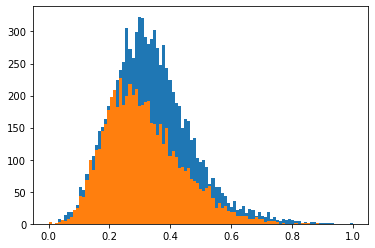

In [34]:
plt.hist(normal, bins=np.linspace(0.0, 1.0, num=100))
plt.hist(anormaly, bins=np.linspace(0.0, 1.0, num=100))
plt.show()

0.3380956 0.3127585
0.1306528 0.1250885


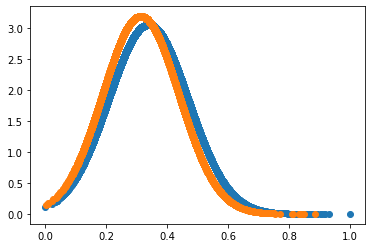

In [35]:
plt.plot(normal, norm.pdf(normal, np.mean(normal), np.std(normal)), 'o')
plt.plot(anormaly, norm.pdf(anormaly, np.mean(anormaly), np.std(anormaly)), 'o')

print(np.mean(normal), np.mean(anormaly))
print(np.std(normal), np.std(anormaly))

In [122]:
def get_example(test_dataset, i):
    ex_img, ex_label = next(iter(test_dataset))
    ex_img = tf.expand_dims(ex_img[i], axis=0)
    ex_label = ex_label[i]
    return ex_img, ex_label

In [124]:
ex_img, ex_label = get_example(test_dataset, 2)

In [125]:
fake_img = generator(ex_img, training=True)

In [126]:
pred, _ = discriminator(ex_img)

In [138]:
pred_int = np.int8(tf.reduce_sum(pred).numpy())

In [139]:
label_int = np.int8(tf.reduce_sum(ex_label).numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'pred : 0')

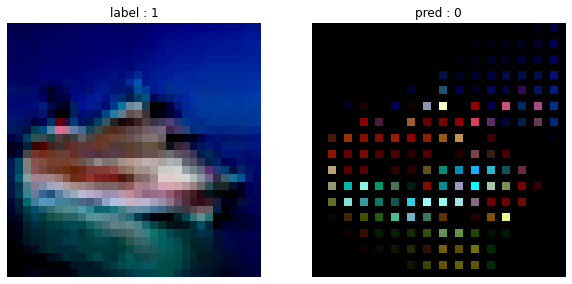

In [140]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(ex_img[0])
plt.axis('off')
plt.title(f'label : {label_int}')

plt.subplot(1,2,2)
plt.imshow(fake_img[0])
plt.axis('off')
plt.title(f'pred : {pred_int}')

### 정리
  
Anomaly detection을 이상치 데이터 없이 정상치 데이터 만으로  
생성모델을 이용해 task를 해결할 수 있다는 점이 흥미롭다.  
  
UNet이 간단하지만 굉장히 성능이 좋고 여러 분야에서 유연하게 쓰이는 것 같다.  
  
GANomarly 모델을 학습시키고 난뒤 test dataset에 대해서는  
이상치와 정상치 구별을 잘 하였다.  
  
하지만 test_data set으로 생성한 이미지에 대해서 이상치 검사를 하였을때  
모델이 오분류 하는 경우가 있었다. 이는 입력으로 넣어준 이미지가  
생성 모델이 출력으로 만들어낸 이미지에서 개구리 처럼 바뀌었기 떄문이다.  
학습이 충분하지 않았는지 생성데이터는 해상도가 매우 낮은 이미지가 생성되었고  
마치 매우 큰 픽셀들이 한 이미지를 이루고 있는 것 처럼 보였다.